## Challenge 1


### Programming challenge

For this challange, I will focus on modelling and evaluating the performances of the machine learning models. 

The dataset is named  ```da6_fulldata.csv.gz```. It contains the following information:

* sessions. Columns ```session_id```, ```session_timestamp```, ```user_agent```, ```referral```, ```type_campaign```.
I will need to provide the details of the browser that visited the site (user_agent), when the visit started, what the referral was, and what campaign the referral came from.

* orders. Columns ```order_euros``` and ```purchase``` include information if a user made a purchase and how much they spent.

* users. Columns ```user_id```, ```reg_name```, ```registration_date```, ```initial_referrer```, ```preferential_client``` and ```age```.
I will need to provide the details of the registered users such as their name, when they created their profile, their age, the referral that they followed when creating their profile, and whether they are part of an exclusive club of preferential clients

For this project, I will need to:
* Propose which control variables are relevant to be included in the model.
* Create the necessary features for different campaigns based on the column ```type_campaign``` (this column includes information about what kind of camapign someone has seen. I can use this information to create the necessary variables for identifying users coming from the CPC or infleuncer campaign) and for my control variables.
* Create models for statistical testing (with **statsmodels**). One only with the campaign information (cpc and infleuncer), and a second model with at least one additional independent or control variable. It can be one of my variables about the session or user. Sales, as a binary variable will be my Dependent Variables.


**Technical** interpretation:

The control variables chosen are the referral used (Google, Facebook, Instagram, Twitter etc.) and the device used for ther purchase (Apple, Android, Windows, Linux etc.).

After summarizing information about the models and the decision tree created, it seems reasonable to consider model 2 better since is the one that shows better performances (a combination of precision and recall). The performance of a model stands for accuracy of the predictions made.

The CPC marketing campaign seem to be the best campaign among all the others. The predictions made shown that the chances of making a purchase are 51.5% if a user has seen the CPC campaign. Instead, if a user has seen the influencerA marketing campaign, the chances of making a purchase are 28.2%. Also, if a user has seen the influencerB marketing campaign the chances of making a purchase are 32%. Additionally, the amount of the purchase in € looks better stimulated by the CPC campaign as well: 95€ is the average purchase made from a user who interacted with CPC  vs 60€ from the influencerB campaign and 28€ from influencerA campaign


**Step-by-step interpretation:**

**Importing libraries**

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import numpy as np

In [3]:
import lime
from lime import lime_tabular

In [4]:
visitors = pd.read_csv('da6_fulldata.csv.gz')

**Exploring the dataset**

In [5]:
visitors.head()

,session_id,order_euros,purchase,session_timestamp,user_agent,referral,type_campaign,user_id,reg_name,age,registration_date,initial_referrer,preferential_client
0,5555694754,153.5,1.0,2021-10-06 16:10:27,Mozilla/5.0 (iPhone; CPU iPhone OS 4_2_1 like ...,facebook.com,CPC,NaN,NaN,NaN,NaN,NaN,NaN
1,5555694755,NaN,NaN,2021-09-30 08:36:38,Opera/8.28.(Windows NT 5.1; lo-LA) Presto/2.9....,facebook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5555694756,NaN,NaN,2021-09-29 15:19:24,Opera/9.44.(Windows NT 6.2; ks-IN) Presto/2.9....,facebook.com,CPC,NaN,NaN,NaN,NaN,NaN,NaN
3,5555694757,NaN,NaN,2021-10-08 02:20:09,Opera/8.34.(Windows NT 10.0; yi-US) Presto/2.9...,facebook.com,influencerA,NaN,NaN,NaN,NaN,NaN,NaN
4,5555694758,NaN,NaN,2021-10-06 19:56:22,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_8...,google.com,organic,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
visitors.columns

Index(['session_id', 'order_euros', 'purchase', 'session_timestamp',
       'user_agent', 'referral', 'type_campaign', 'user_id', 'reg_name', 'age',
       'registration_date', 'initial_referrer', 'preferential_client'],
      dtype='object')

In [7]:
visitors.isna().sum()

session_id                 0
order_euros            37499
purchase               37499
session_timestamp          0
user_agent                 0
referral                   0
type_campaign          23629
user_id                34822
reg_name               34822
age                    34822
registration_date      34822
initial_referrer       34822
preferential_client    47028
dtype: int64

In [8]:
len(visitors)

50000

In [9]:
visitors.dtypes

session_id               int64
order_euros            float64
purchase               float64
session_timestamp       object
user_agent              object
referral                object
type_campaign           object
user_id                float64
reg_name                object
age                    float64
registration_date       object
initial_referrer        object
preferential_client    float64
dtype: object

**Among the 50k visitors there were 12.501 purchases**

In [10]:
visitors['purchase'].value_counts()

1.0    12501
Name: purchase, dtype: int64

**There were only 3 main referrals, namely Google, Facebook and Instagram**

In [11]:
visitors['referral'].value_counts()

google.com                 11127
facebook.com               11109
instagram.com              11045
smith.com                    151
johnson.com                  108
                           ...  
rojas.org                      1
cruz-scott.com                 1
buck-rodriguez.com             1
rivera-howard.biz              1
hunter-fitzpatrick.info        1
Name: referral, Length: 8597, dtype: int64

**There are 5 different marketing campaigns**

In [12]:
visitors['type_campaign'].value_counts()

influencerA    8405
influencerB    6328
CPC            5252
SEA            3202
organic        3184
Name: type_campaign, dtype: int64

**There are 2972 visitors which are preferential clients**

In [13]:
visitors['preferential_client'].value_counts()

1.0    2972
Name: preferential_client, dtype: int64

**Average order in € is 177.50€, the smallest order is 110,00€ and the biggest is 439,00€**

In [14]:
visitors['order_euros'].describe()

count    12501.000000
mean       177.550356
std         53.545786
min        110.100000
25%        137.600000
50%        162.100000
75%        203.400000
max        439.200000
Name: order_euros, dtype: float64

**Fixing missing values with a zero since the missing values are the visitors who did not purchase**

In [15]:
visitors['order_euros'] = visitors['order_euros'].fillna(0)
visitors['purchase'] = visitors['purchase'].fillna(0)
visitors['preferential_client'] = visitors['preferential_client'].fillna(0)

**Categorizing campaigns in order to create my binary variables with a word query in the next steps**

In [16]:
visitors['type_campaign'] = visitors['type_campaign'].fillna('Other_campaigns')

In [17]:
def recategorize(category):
    if category == 'influencerA':
        return 'influencerA'
    if category == 'influencerB':
        return 'influencerB'
    if category == 'CPC':
        return 'CPC'
   
    else:
        return 'Other_campaigns'

In [18]:
visitors['type_campaign'] = visitors['type_campaign'].apply(recategorize)

In [19]:
def wordlist_any_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [20]:
visitors['InfluencerA'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['InfluencerA'],))
visitors['InfluencerB'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['InfluencerB'],))
visitors['CPC'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['CPC'],))
visitors['Other_campaigns'] = visitors['type_campaign'].apply(wordlist_any_present, args=(['other_campaigns'],))

In [21]:
visitors['InfluencerA'].value_counts()

0    41595
1     8405
Name: InfluencerA, dtype: int64

In [22]:
visitors['InfluencerB'].value_counts()

0    43672
1     6328
Name: InfluencerB, dtype: int64

In [23]:
visitors['CPC'].value_counts()

0    44748
1     5252
Name: CPC, dtype: int64

In [24]:
visitors.isna().sum()

session_id                 0
order_euros                0
purchase                   0
session_timestamp          0
user_agent                 0
referral                   0
type_campaign              0
user_id                34822
reg_name               34822
age                    34822
registration_date      34822
initial_referrer       34822
preferential_client        0
InfluencerA                0
InfluencerB                0
CPC                        0
Other_campaigns            0
dtype: int64

In [25]:
visitors['Other_campaigns'].value_counts()

1    30015
0    19985
Name: Other_campaigns, dtype: int64

In [26]:
visitors['purchase'] = visitors['purchase'].astype(int)

In [27]:
visitors['preferential_client'] = visitors['preferential_client'].astype(int)

In [28]:
visitors['referral'].value_counts()

google.com                 11127
facebook.com               11109
instagram.com              11045
smith.com                    151
johnson.com                  108
                           ...  
rojas.org                      1
cruz-scott.com                 1
buck-rodriguez.com             1
rivera-howard.biz              1
hunter-fitzpatrick.info        1
Name: referral, Length: 8597, dtype: int64

**Categorizing referrals and making dummy variables out of it for further analysis**

In [29]:
def recategorize(category):
    if category == 'google.com':
        return 'google.com'
    if category == 'facebook.com':
        return 'facebook.com'
    if category == 'instagram.com':
        return 'instagram.com'
   
    else:
        return 'Other_referral'

In [30]:
visitors['referral'] = visitors['referral'].apply(recategorize)

In [31]:
visitors['referral'].value_counts()

Other_referral    16719
google.com        11127
facebook.com      11109
instagram.com     11045
Name: referral, dtype: int64

In [32]:
def wordlist_any_present(text, query):
    import re
    text = str(text).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", text)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [33]:
visitors['Google'] = visitors['referral'].apply(wordlist_any_present, args=(['google'],))
visitors['Facebook'] = visitors['referral'].apply(wordlist_any_present, args=(['facebook'],))
visitors['Instagram'] = visitors['referral'].apply(wordlist_any_present, args=(['instagram'],))
visitors['Other_referral'] = visitors['referral'].apply(wordlist_any_present, args=(['Other_referral'],))

In [34]:
visitors['Apple_device'] = visitors['user_agent'].apply(wordlist_any_present, args=(['Macintosh', 'iOS','ipad', 'apple', 'iphone'],))

In [35]:
visitors['Apple_device'].value_counts()

0    35363
1    14637
Name: Apple_device, dtype: int64

In [36]:
visitors_ = visitors[['session_id','purchase','order_euros','preferential_client','user_agent','referral','Google','Facebook','Instagram','Other_referral','type_campaign','InfluencerA','InfluencerB','CPC','Other_campaigns','Apple_device']]

In [37]:
visitors_['purchase'].value_counts()

0    37499
1    12501
Name: purchase, dtype: int64

In [38]:
visitors_['purchase'].value_counts(normalize=True)

0    0.74998
1    0.25002
Name: purchase, dtype: float64

**This is the average order in €, the minimum order and the max but including the visitors who did not purchase anything**

In [39]:
visitors_['order_euros'].describe()

count    50000.00000
mean        44.39114
std         81.41259
min          0.00000
25%          0.00000
50%          0.00000
75%        110.10000
max        439.20000
Name: order_euros, dtype: float64

In [40]:
visitors_['type_campaign'].value_counts()

Other_campaigns    30015
influencerA         8405
influencerB         6328
CPC                 5252
Name: type_campaign, dtype: int64

In [41]:
visitors_['type_campaign'].value_counts(normalize=True)

Other_campaigns    0.60030
influencerA        0.16810
influencerB        0.12656
CPC                0.10504
Name: type_campaign, dtype: float64

**a 25% of our sample did purchase something**

In [42]:
visitors_[['order_euros','purchase']].describe()

,order_euros,purchase
count,50000.00000,50000.000000
mean,44.39114,0.250020
std,81.41259,0.433029
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.00000,0.000000
75%,110.10000,1.000000
max,439.20000,1.000000


**As we can see from the statistics, the CPC campaign was the most profitable. With the CPC campaign the chances of making a purchase are 51.5% vs 32% with influencerB campaign vs 28% influencerA campaign vs 17% from other campaigns. The CPC campaign is the one which stimulated the highest amount of order in €: 95€ is the average purchase made with it vs 60€ from the influencerB campaign and 28€ with influencerA campaign**

In [43]:
visitors_.groupby('type_campaign')[['purchase','order_euros']].describe().transpose()

type_campaign              CPC  Other_campaigns  influencerA  influencerB
purchase    count  5252.000000     30015.000000  8405.000000  6328.000000
            mean      0.515232         0.179777     0.282332     0.320164
            std       0.499816         0.384008     0.450161     0.466576
            min       0.000000         0.000000     0.000000     0.000000
            25%       0.000000         0.000000     0.000000     0.000000
            50%       1.000000         0.000000     0.000000     0.000000
            75%       1.000000         0.000000     1.000000     1.000000
            max       1.000000         1.000000     1.000000     1.000000
order_euros count  5252.000000     30015.000000  8405.000000  6328.000000
            mean     95.604303        29.627593    52.829518    60.704630
            std     100.676800        66.508137    89.106578    94.148035
            min       0.000000         0.000000     0.000000     0.000000
            25%       0.000000         0.000000     0.000000     0.000000
            50%     118.400000         0.000000     0.000000     0.000000
            75%     162.200000         0.000000   125.300000   150.200000
            max     439.200000       391.300000   436.400000   434.300000

**Visualization of the visitors who have made a purchase**

<AxesSubplot:xlabel='purchase', ylabel='count'>

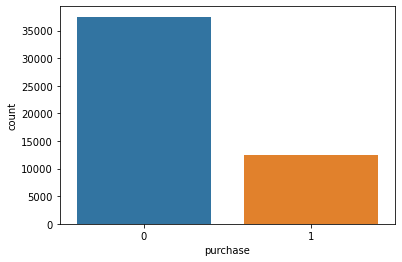

In [44]:
sns.countplot(x='purchase', data=visitors_)

**Distribution of the order in €**

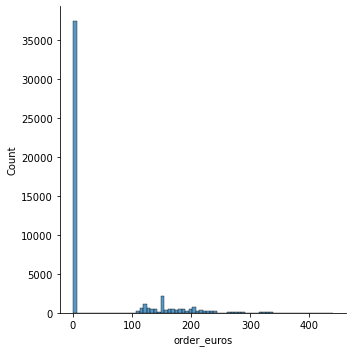

In [45]:
sns.displot(visitors_['order_euros']) 

**Amount of Apple devices used among our visitors**

<AxesSubplot:xlabel='Apple_device', ylabel='count'>

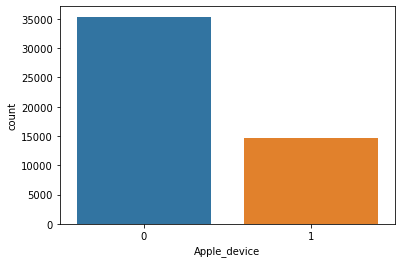

In [46]:
sns.countplot(x='Apple_device', data=visitors_)

**Visualization of thr campaigns' reach. As we can see the CPC campaign is the most profitable even if is the one that attracted the smallest amount of visitors**

<AxesSubplot:xlabel='count', ylabel='type_campaign'>

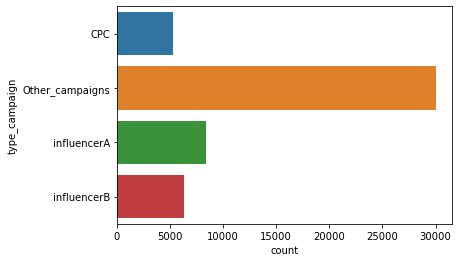

In [47]:
sns.countplot(y='type_campaign', data=visitors_) 

<AxesSubplot:xlabel='count', ylabel='referral'>

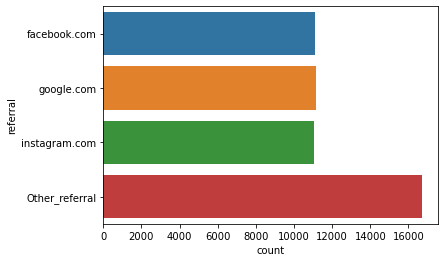

In [48]:
sns.countplot(y='referral', data=visitors_)

**Visualization of the purchases made through different campaigns**

<AxesSubplot:xlabel='type_campaign', ylabel='purchase'>

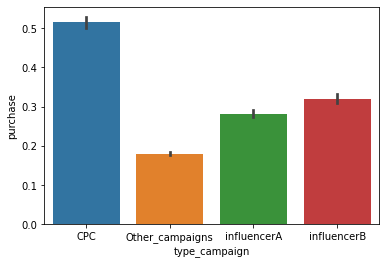

In [49]:
sns.barplot(x='type_campaign', y='purchase', data=visitors_)

**Visualization of the order in € made through different campaigns**

<AxesSubplot:xlabel='referral', ylabel='order_euros'>

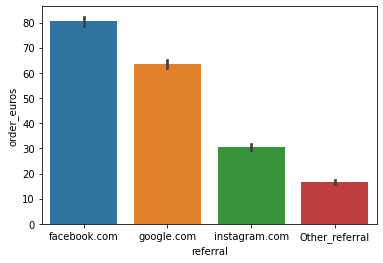

In [50]:
sns.barplot(x='referral', y='order_euros', data=visitors_)

**Importing an additional library which I will use to split and train my dataset. A portion of it will be used to train the model (machine learning) and consequently will be known to the model. The second portion of our dataset will be kept unknown to the model and will be used to test the performance of the results since the model will be making prediction on it**  

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
visitors_.dtypes

session_id               int64
purchase                 int64
order_euros            float64
preferential_client      int64
user_agent              object
referral                object
Google                   int64
Facebook                 int64
Instagram                int64
Other_referral           int64
type_campaign           object
InfluencerA              int64
InfluencerB              int64
CPC                      int64
Other_campaigns          int64
Apple_device             int64
dtype: object

**Splitting my data keeping a 20% of it (10k observations) for testing the result and an 80% (40k) to train the model**

In [53]:
train, test = train_test_split(visitors_, test_size=0.2, random_state=42)

In [54]:
len(train), len(test)

(40000, 10000)

**Setting purchase (binary) as Dependent variable and the CPC campaign as the Independent Variable**

In [55]:
target = "purchase"
features = ['CPC']

In [56]:
logit_stats = sm.Logit(train[target], sm.add_constant(train[features]))

In [57]:
result_logit = logit_stats.fit()

Optimization terminated successfully.
         Current function value: 0.541523
         Iterations 5


In [58]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39998
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                 0.03498
Time:                        17:36:10   Log-Likelihood:                -21661.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2801      0.013    -99.918      0.000      -1.305      -1.255
CPC            1.3443      0.033     40.243      0.000       1.279       1.410


**Setting purchase (binary) as Dependent variable and the CPC campaign as the Independent Variable and the device used and the referral as control variables. The pseudo R2 of this model (even if it is performing quite poorly so reliability of this model is niot strong) is the highest among all the other model performed so this will be the one used to make predictions. We can see that the coefficent of CPC campaign is positive (1.47) and significant. If compared to the coefficent of the other marketing campaign we can see that CPC campaign is the one showing the most positive results**

In [59]:
features_controls = ['CPC','Apple_device','Google']

In [60]:
logit_stats_user = sm.Logit(train[target], sm.add_constant(train[features_controls]))

In [61]:
result_logit_user = logit_stats_user.fit()

Optimization terminated successfully.
         Current function value: 0.488568
         Iterations 6


In [62]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39996
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                  0.1293
Time:                        17:36:10   Log-Likelihood:                -19543.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0410      0.020   -102.011      0.000      -2.080      -2.002
CPC              1.4736      0.036     40.870      0.000       1.403       1.544
Apple_device     1.5331      0.026     59.28

**Setting a new model with purchase (binary) as Dependent variable and the InfluencerA campaign as the Independent Variable**

In [63]:
target = "purchase"
features = ['InfluencerA']

In [64]:
logit_stats1= sm.Logit(train[target], sm.add_constant(train[features]))

In [65]:
result_logit = logit_stats1.fit()

Optimization terminated successfully.
         Current function value: 0.560569
         Iterations 5


In [66]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39998
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                0.001037
Time:                        17:36:10   Log-Likelihood:                -22423.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                 8.866e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1404      0.013    -89.176      0.000      -1.166      -1.115
InfluencerA     0.2069      0.030      6.892      0.000       0.148       0.266


**Setting a new model with purchase (binary) as Dependent variable and the InfluencerA campaign as the Independent Variable with the device used and the referral as my control variables**

In [67]:
features_controls1 = ['InfluencerA','Apple_device','Google']

In [68]:
logit_stats_user1 = sm.Logit(train[target], sm.add_constant(train[features_controls1]))

In [69]:
result_logit_user = logit_stats_user1.fit()

Optimization terminated successfully.
         Current function value: 0.506501
         Iterations 6


In [70]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39996
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                 0.09739
Time:                        17:36:11   Log-Likelihood:                -20260.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9428      0.020    -95.179      0.000      -1.983      -1.903
InfluencerA      0.4847      0.033     14.604      0.000       0.420       0.550
Apple_device     1.4592      0.025     58.24

**Setting a new model with purchase (binary) as Dependent variable and the InfluencerB campaign as the Independent Variable**

In [71]:
target = "purchase"
features = ['InfluencerB']

In [72]:
logit_stats2 = sm.Logit(train[target], sm.add_constant(train[features]))

In [73]:
result_logit = logit_stats2.fit()

Optimization terminated successfully.
         Current function value: 0.559219
         Iterations 5


In [74]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39998
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                0.003443
Time:                        17:36:11   Log-Likelihood:                -22369.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                 1.730e-35
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1615      0.013    -92.459      0.000      -1.186      -1.137
InfluencerB     0.4121      0.033     12.671      0.000       0.348       0.476


**Setting a new model with purchase (binary) as Dependent variable and the InfluencerA campaign as the Independent Variable with the device used and the referral as control variables**

In [75]:
features_controls2 = ['InfluencerB','Apple_device','Google']

In [76]:
logit_stats_user = sm.Logit(train[target], sm.add_constant(train[features_controls2]))

In [77]:
result_logit_user = logit_stats_user.fit()

Optimization terminated successfully.
         Current function value: 0.503950
         Iterations 6


In [78]:
print(result_logit_user.summary())

                           Logit Regression Results                           
Dep. Variable:               purchase   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39996
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Sep 2023   Pseudo R-squ.:                  0.1019
Time:                        17:36:11   Log-Likelihood:                -20158.
converged:                       True   LL-Null:                       -22446.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.9742      0.020    -97.539      0.000      -2.014      -1.935
InfluencerB      0.7419      0.036     20.741      0.000       0.672       0.812
Apple_device     1.4754      0.025     58.55

**Making some prediction about the odds of making a purchase with different marketing campaigs**

In [79]:
logit_clf = LogisticRegression(max_iter=1000, fit_intercept = True)

In [80]:
features = ['CPC',  'InfluencerA', 'InfluencerB']

In [81]:
logit_clf.fit(train[features], train[target])

LogisticRegression(max_iter=1000)

**If a user sees the CPC marketing campaign the chances of making a purchase are 51.5%. Instead, if a user sees the influencerA marketing campaign the chances of making a purchase are 28.2%. Also, if a user sees the influencer marketing campaign the chances of making a purchase are 32%. Predictions are completely in line with the descriptive statistics shown previously**

In [82]:
logit_clf.predict_proba([[1,0,0]])

array([[0.48433188, 0.51566812]])

In [83]:
logit_clf.predict_proba([[0,1,0]])

array([[0.71787546, 0.28212454]])

In [84]:
logit_clf.predict_proba([[0,0,1]])

array([[0.67918345, 0.32081655]])

**Making predictions adding the control variables**

In [85]:
logit_clf_user = LogisticRegression(max_iter=1000, fit_intercept = True)

In [86]:
logit_clf_user.fit(train[features_controls], train[target])

LogisticRegression(max_iter=1000)

In [87]:
features_controls

['CPC', 'Apple_device', 'Google']

**If a user sees the CPC marketing campaign without an Apple device and not through Google as referral, the chances of making a purchase are 36%. Instead, if a user sees the CPC marketing campaign with an Apple device and not through Google as referral, the chances of making a purchase are 72%. Also, if a user sees the CPC marketing campaign with an Apple device and through Google as referral, the chances of making a purchase are 85%**

In [88]:
logit_clf_user.predict_proba([[1,0,0]])

array([[0.63841824, 0.36158176]])

In [89]:
logit_clf_user.predict_proba([[1,1,0]])

array([[0.27622238, 0.72377762]])

In [90]:
logit_clf_user.predict_proba([[1,1,1]])

array([[0.15279732, 0.84720268]])

In [91]:
test['predicted_bounce_logit'] = logit_clf.predict(test[features])

<ipython-input-91-9fbbfa671ffe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_bounce_logit'] = logit_clf.predict(test[features])


**Checking how many predicted purchases have been detected by the model: 1.045 users have been predicted to make a purchase**

In [92]:
test['predicted_bounce_logit'].value_counts()

0    8955
1    1045
Name: predicted_bounce_logit, dtype: int64

**Comparig the predictions to the actual resuts. Among a random sample of 5 values, we can see that 2 were not correct**

In [93]:
test[['purchase', 'predicted_bounce_logit']].head()

,purchase,predicted_bounce_logit
33553,0,0
9427,1,0
199,0,0
12447,0,0
39489,1,0


**Adding the control variables to see if the model improves its performances**

In [94]:
test['predicted_bounce_logit_user'] = logit_clf_user.predict(test[features_controls])

<ipython-input-94-410e8bc40bfd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_bounce_logit_user'] = logit_clf_user.predict(test[features_controls])


In [95]:
test['predicted_bounce_logit_user'].value_counts()

0    8891
1    1109
Name: predicted_bounce_logit_user, dtype: int64

**Comparig the predictions made with and without control variables with the the actual resuts. Among a random sample of 5 values, we can see that 2 were still not correct, the model didn't look improving a lot**

In [96]:
test[['purchase', 'predicted_bounce_logit', 'predicted_bounce_logit_user']].head()

,purchase,predicted_bounce_logit,predicted_bounce_logit_user
33553,0,0,0
9427,1,0,0
199,0,0,0
12447,0,0,0
39489,1,0,0


In [97]:
from sklearn.metrics import confusion_matrix

**Looking at the performance matrix: the matrix shows us that 510 users were tagged as false positives and 2009 as false negatives. 6946 users were indeed non purchasers and the model predictit them as such and 535 were indeed purchasers and the model predicted them as such**

In [98]:
print(confusion_matrix(test['purchase'], test['predicted_bounce_logit']))

[[6946  510]
 [2009  535]]


**Looking at the performance matrix if I add the control variables: the matrix show some improvments since now only 283 users were tagged as false positives and 1718 as false negatives. Now 7173 users were non purchasers and the model predictit them as such and 826 were purchasers and the model predicted them as such**

In [99]:
print(confusion_matrix(test['purchase'], test['predicted_bounce_logit_user']))

[[7173  283]
 [1718  826]]


**Comparing the 2 models (with and without control variables): model 1 seem to have more recall (0.75) and a little less precision (0.71). The second model seems as well to have more recall (0.80) [True Positives / (True Positives + False Negatives) which means how many relevant items were selected, so how many false negative were positive], and slightly  less precision (0.79) [true Positives / (True Positives + False Positives) which means how many selected items, purchase, were false negative or true negative], but anyway it performed better than the first model among both values. In the overall the F1 scores (combination of precision and recall) show us that the second model is performing better (0.71 F1 score model 1 vs 0.77 F1 score model 2) so is the one will be chosen**

In [100]:
from sklearn.metrics import classification_report

In [101]:
print(classification_report(test['purchase'], test['predicted_bounce_logit']))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      7456
           1       0.51      0.21      0.30      2544

    accuracy                           0.75     10000
   macro avg       0.64      0.57      0.57     10000
weighted avg       0.71      0.75      0.71     10000



In [102]:
print(classification_report(test['purchase'], test['predicted_bounce_logit_user']))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      7456
           1       0.74      0.32      0.45      2544

    accuracy                           0.80     10000
   macro avg       0.78      0.64      0.66     10000
weighted avg       0.79      0.80      0.77     10000



**Importimg libraries to make a decision tree**

In [103]:
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._export import plot_tree

In [104]:
dt_clf = DecisionTreeClassifier()

In [105]:
dt_clf.fit(train[features], train[target])

DecisionTreeClassifier()

**Making a decision tree without control variables**

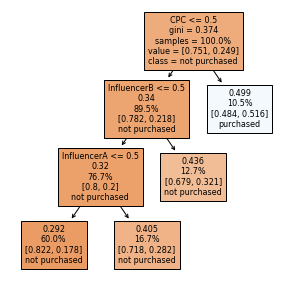

In [106]:
plt.figure(figsize=(5,5))
plot_tree(dt_clf, proportion=True, label='root', 
          feature_names=['CPC',  'InfluencerA', 'InfluencerB'], class_names=['not purchased','purchased'], filled=True, fontsize=8)
plt.show()

In [107]:
test['predicted_purchase'] = dt_clf.predict(test[features])

<ipython-input-107-0c3d6b09c017>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_purchase'] = dt_clf.predict(test[features])


In [108]:
dt_clf_user = DecisionTreeClassifier()

In [109]:
dt_clf_user.fit(train[features_controls], train[target])

DecisionTreeClassifier()

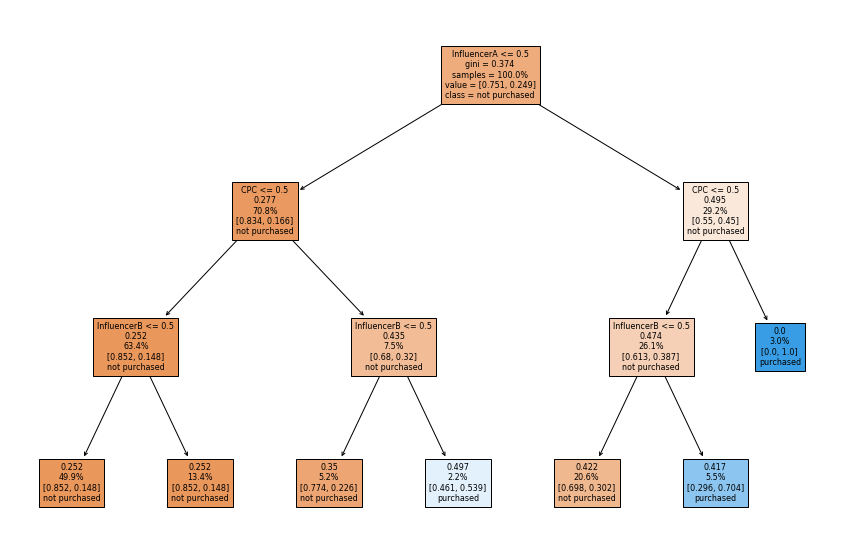

In [110]:
plt.figure(figsize=(15,10))
plot_tree(dt_clf_user, proportion=True, 
          label='root', 
          feature_names=['CPC','InfluencerA', 'InfluencerB', 'Apple_device','Google'], 
          class_names=['not purchased','purchased'], 
          filled=True, fontsize=8)
plt.show()

In [111]:
test['predicted_purchase_user'] = dt_clf_user.predict(test[features_controls])

<ipython-input-111-a344e5452caa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_purchase_user'] = dt_clf_user.predict(test[features_controls])


**Showing performances of the two decision trees**

In [112]:
print(classification_report(test['purchase'], test['predicted_purchase']))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      7456
           1       0.51      0.21      0.30      2544

    accuracy                           0.75     10000
   macro avg       0.64      0.57      0.57     10000
weighted avg       0.71      0.75      0.71     10000



In [113]:
print(classification_report(test['purchase'], test['predicted_purchase_user']))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      7456
           1       0.74      0.32      0.45      2544

    accuracy                           0.80     10000
   macro avg       0.78      0.64      0.66     10000
weighted avg       0.79      0.80      0.77     10000

